### Description
##### Model architecture
- wider li
- huber loss

##### Dataset
- Full 15 min, 28 instruments dataset from Jun 2021 to Sept 2021
- is compound conditions regarding close, low and high

##### Results
- thrash, model didnt move
- weights seem fine, so not vanishing gradients
- Final model location at models/20211026082249_negative_non_bin_v2_epoch_100

##### Conclusion
- relu not what we want

##### Next steps



In [1]:
from __init__ import *

In [2]:
consecutive = 12
n_candles_as_x = 5
take_profit_pips = -20 
stop_loss_pips = 20
model_type = 'negative_non_bin_v2'

In [3]:
TRAINING_DATA_FOLDER = 'training_data/'
COMPILED_FOLDER = TRAINING_DATA_FOLDER + 'compiled/'
filename = '28_instruments_20210601000000_to_20210901000000_20211020230802.csv'
df = pd.read_csv(COMPILED_FOLDER + filename)
del df['Unnamed: 0']

In [4]:
mine = Mine_v2(df, consecutive, n_candles_as_x, take_profit_pips, stop_loss_pips)

In [5]:
#--------- feature extraction ---------#
mine.extract_body_height()
mine.extract_upper_wick_height()
mine.extract_lower_wick_height()
mine.extract_all_increments_to_i_candle()

#------- label processing -------#
mine.extract_high_score(type='multiplier')
mine.extract_close_score(close_score_pips=10, close_type='ceiling')
mine.extract_low_score(type='increment')
mine.extract_compound_score(
        increment_label='low_score',
        multipler_label='high_score'
)

#-------- clean up -------#
mine.drop_intermediate_headers()
mine.drop_original_headers()

other_headers = ['body_height', 'upper_wick', 'lower_wick']
other_headers = [header+str(n) for n in range(n_candles_as_x, consecutive) for header in other_headers]
mine.drop_headers(other_headers)

#----------#
df = mine.df
# mine.df

In [6]:
# df[df['y'] > 0.9]

In [7]:
# import plotly.graph_objects as go
# xdf = mine.df[mine.df['y'] > 0.9]
# start_candle = 3
# end_candle = 11

# for n in range(10):
#     item = xdf.iloc[n]
    
#     mid_of_last_input_candle = sum([item['close{}'.format(3)], item['open{}'.format(4)]])/2
#     close_price = mid_of_last_input_candle + pip_to_currency(10)
#     print('close_price = {}'.format(close_price))
#     print('y = {}'.format(item['y']))
               
#     opens = [item['open{}'.format(i)] for i in range(start_candle, end_candle)]
#     closes = [item['close{}'.format(i)] for i in range(start_candle, end_candle)]
#     lows = [item['low{}'.format(i)] for i in range(start_candle, end_candle)]
#     highs = [item['high{}'.format(i)] for i in range(start_candle, end_candle)]

#     fig = go.Figure(data=[go.Candlestick(
#         open=opens,
#         high=highs,
#         low=lows,
#         close=closes)])

#     fig.show()

In [8]:
#-------- split.py ----------# 
dfs = train_test_val_split(df)
datasets = get_datasets(dfs)
dataloaders = get_dataloaders(datasets)

In [9]:
#--------- networks.py ----------#
import torch.nn as nn
class NeuralNetwork(nn.Module, NetMixin):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(19, 100),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(100, 200),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(200, 50),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
#----------- network, netMixin ------------------#
import torch.nn.functional as F
import torch.nn as nn
net = NeuralNetwork()


epochs = 100
loss_fn = nn.HuberLoss() # huberloss
learning_rate = 0.003
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
save_location = MODEL_FOLDER + str(ctime.from_now()) + '_' + model_type
print('Save location: {}'.format(save_location))

losses = net.train_model(
    dataloaders['train'],
    dataloaders['val'],
    epochs,
    optimizer,
    loss_fn,
    device='cpu',
    print_every=1,
    save_every=10,
    validate_every=5,
    save_location=save_location
)

Save location: ../../models/20211026234531_negative_non_bin_v2
---------- Epoch 1 of 100 @ 26-10-2021 23:45:31 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01153955768175341

---------- Epoch 2 of 100 @ 26-10-2021 23:47:13 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011540791056198263

---------- Epoch 3 of 100 @ 26-10-2021 23:49:00 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01153884642909008

---------- Epoch 4 of 100 @ 26-10-2021 23:50:44 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011541759209317597

---------- Epoch 5 of 100 @ 26-10-2021 23:52:29 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011551449412458205


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.012

---------- Epoch 6 of 100 @ 26-10-2021 23:54:17 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011543604770591761

---------- Epoch 7 of 100 @ 26-10-2021 23:56:00 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01154453521489028

---------- Epoch 8 of 100 @ 26-10-2021 23:57:43 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011299128033764701

---------- Epoch 9 of 100 @ 26-10-2021 23:59:26 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.011043660642156481

---------- Epoch 10 of 100 @ 27-10-2021 00:01:09 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01091689475147024


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 11 of 100 @ 27-10-2021 00:02:57 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010863957405876073

---------- Epoch 12 of 100 @ 27-10-2021 00:04:40 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010836370365595411

---------- Epoch 13 of 100 @ 27-10-2021 00:06:30 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010805326421590144

---------- Epoch 14 of 100 @ 27-10-2021 00:08:25 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010787930022906792

---------- Epoch 15 of 100 @ 27-10-2021 00:10:21 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010778296373421741


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 16 of 100 @ 27-10-2021 00:12:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01077221865559538

---------- Epoch 17 of 100 @ 27-10-2021 00:14:13 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010763456337545886

---------- Epoch 18 of 100 @ 27-10-2021 00:16:07 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010755274960986924

---------- Epoch 19 of 100 @ 27-10-2021 00:18:01 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010764689326458498

---------- Epoch 20 of 100 @ 27-10-2021 00:19:54 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010755141929677435


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 21 of 100 @ 27-10-2021 00:21:53 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010752742569416157

---------- Epoch 22 of 100 @ 27-10-2021 00:23:46 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010743469063021765

---------- Epoch 23 of 100 @ 27-10-2021 00:25:39 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010742232335372658

---------- Epoch 24 of 100 @ 27-10-2021 00:27:33 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010732051491198444

---------- Epoch 25 of 100 @ 27-10-2021 00:29:27 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010743736690746821


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 26 of 100 @ 27-10-2021 00:31:24 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.0107262343695636

---------- Epoch 27 of 100 @ 27-10-2021 00:33:18 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010712606365414953

---------- Epoch 28 of 100 @ 27-10-2021 00:35:13 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010726194963344917

---------- Epoch 29 of 100 @ 27-10-2021 00:37:06 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010728791359420314

---------- Epoch 30 of 100 @ 27-10-2021 00:39:00 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010714083064242711


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 31 of 100 @ 27-10-2021 00:40:57 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010717633240212894

---------- Epoch 32 of 100 @ 27-10-2021 00:42:51 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010703512880920113

---------- Epoch 33 of 100 @ 27-10-2021 00:44:46 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01070978861284418

---------- Epoch 34 of 100 @ 27-10-2021 00:46:39 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010700104011040469

---------- Epoch 35 of 100 @ 27-10-2021 00:48:33 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010699783180604435


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 36 of 100 @ 27-10-2021 00:50:31 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010708161596109742

---------- Epoch 37 of 100 @ 27-10-2021 00:52:25 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010703437930919789

---------- Epoch 38 of 100 @ 27-10-2021 00:54:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010701660842516362

---------- Epoch 39 of 100 @ 27-10-2021 00:56:11 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01068514744683656

---------- Epoch 40 of 100 @ 27-10-2021 00:58:06 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010696236758159327


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 41 of 100 @ 27-10-2021 01:00:03 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010696859628719753

---------- Epoch 42 of 100 @ 27-10-2021 01:01:58 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010682970684707312

---------- Epoch 43 of 100 @ 27-10-2021 01:03:52 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010680051454779557

---------- Epoch 44 of 100 @ 27-10-2021 01:05:46 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.0106713688979186

---------- Epoch 45 of 100 @ 27-10-2021 01:07:40 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010675616863932704


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 46 of 100 @ 27-10-2021 01:09:37 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010686795339408023

---------- Epoch 47 of 100 @ 27-10-2021 01:11:32 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01067201644030516

---------- Epoch 48 of 100 @ 27-10-2021 01:13:25 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010671384925226807

---------- Epoch 49 of 100 @ 27-10-2021 01:15:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01068529532154005

---------- Epoch 50 of 100 @ 27-10-2021 01:17:12 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010669714725391159


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 51 of 100 @ 27-10-2021 01:19:09 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01067420580677922

---------- Epoch 52 of 100 @ 27-10-2021 01:20:57 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010655867002766954

---------- Epoch 53 of 100 @ 27-10-2021 01:22:42 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010652272329010929

---------- Epoch 54 of 100 @ 27-10-2021 01:24:24 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010685356936357806

---------- Epoch 55 of 100 @ 27-10-2021 01:26:06 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010690937000634107


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 56 of 100 @ 27-10-2021 01:27:52 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010670349188207145

---------- Epoch 57 of 100 @ 27-10-2021 01:29:34 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01065028958164171

---------- Epoch 58 of 100 @ 27-10-2021 01:31:22 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010646969527767728

---------- Epoch 59 of 100 @ 27-10-2021 01:33:13 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010655803429636927

---------- Epoch 60 of 100 @ 27-10-2021 01:35:03 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01064913004563739


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 61 of 100 @ 27-10-2021 01:36:56 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010647281529913679

---------- Epoch 62 of 100 @ 27-10-2021 01:38:41 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010635739632242958

---------- Epoch 63 of 100 @ 27-10-2021 01:40:27 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01063530921675076

---------- Epoch 64 of 100 @ 27-10-2021 01:42:17 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010652998229729241

---------- Epoch 65 of 100 @ 27-10-2021 01:44:10 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010647664016087762


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 66 of 100 @ 27-10-2021 01:46:04 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010671513691295029

---------- Epoch 67 of 100 @ 27-10-2021 01:47:52 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01065286631015853

---------- Epoch 68 of 100 @ 27-10-2021 01:49:41 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010634073805151039

---------- Epoch 69 of 100 @ 27-10-2021 01:51:35 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010638427282224793

---------- Epoch 70 of 100 @ 27-10-2021 01:53:30 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010620033732343423


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 71 of 100 @ 27-10-2021 01:55:29 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010641569005153657

---------- Epoch 72 of 100 @ 27-10-2021 01:57:22 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010642124840378343

---------- Epoch 73 of 100 @ 27-10-2021 01:59:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010644356195680691

---------- Epoch 74 of 100 @ 27-10-2021 02:01:18 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01062573713738213

---------- Epoch 75 of 100 @ 27-10-2021 02:03:17 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010636456400129352


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 76 of 100 @ 27-10-2021 02:05:21 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010628761302039998

---------- Epoch 77 of 100 @ 27-10-2021 02:07:21 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010619152437185954

---------- Epoch 78 of 100 @ 27-10-2021 02:09:20 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01062426804232318

---------- Epoch 79 of 100 @ 27-10-2021 02:11:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010630731286730392

---------- Epoch 80 of 100 @ 27-10-2021 02:13:20 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010619651507262727


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 81 of 100 @ 27-10-2021 02:15:24 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010607868558153448

---------- Epoch 82 of 100 @ 27-10-2021 02:17:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01061341259442838

---------- Epoch 83 of 100 @ 27-10-2021 02:19:18 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010598333558363853

---------- Epoch 84 of 100 @ 27-10-2021 02:21:16 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010618372208191345

---------- Epoch 85 of 100 @ 27-10-2021 02:23:15 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010604710526754369


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 86 of 100 @ 27-10-2021 02:25:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01060744965972102

---------- Epoch 87 of 100 @ 27-10-2021 02:27:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010596895925550317

---------- Epoch 88 of 100 @ 27-10-2021 02:29:19 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010595033595413503

---------- Epoch 89 of 100 @ 27-10-2021 02:31:20 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010617760666600534

---------- Epoch 90 of 100 @ 27-10-2021 02:33:17 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010616861739696972


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 91 of 100 @ 27-10-2021 02:35:26 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010610338556324634

---------- Epoch 92 of 100 @ 27-10-2021 02:37:28 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010604723066150245

---------- Epoch 93 of 100 @ 27-10-2021 02:39:30 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01060820009404482

---------- Epoch 94 of 100 @ 27-10-2021 02:41:30 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010615990709917126

---------- Epoch 95 of 100 @ 27-10-2021 02:43:30 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010605538047211694


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011

---------- Epoch 96 of 100 @ 27-10-2021 02:45:35 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010602881127563612

---------- Epoch 97 of 100 @ 27-10-2021 02:47:27 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.01060588999024726

---------- Epoch 98 of 100 @ 27-10-2021 02:49:24 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010589895889067797

---------- Epoch 99 of 100 @ 27-10-2021 02:51:11 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010580696468872991

---------- Epoch 100 of 100 @ 27-10-2021 02:52:56 ----------


  0%|          | 0/2602 [00:00<?, ?it/s]

Average training loss: 0.010587022643748695


  0%|          | 0/372 [00:00<?, ?it/s]

Average Validation Loss: 0.011



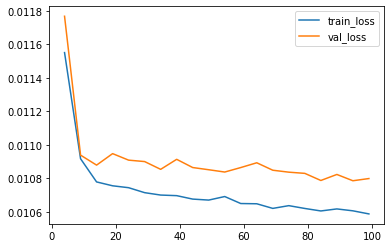

In [11]:
#----------- interpret --------------#
indexes, train_loss, val_loss = unpack_losses(losses)
plot(indexes, (train_loss, val_loss), ['train_loss', 'val_loss'])

In [12]:
# for param in net.parameters():
#     print(param)

In [14]:
n_inputs = 19
threshold = 0.55
model_path = '../../models/20211026234531_negative_non_bin_v2_epoch_100'
model_class = NeuralNetwork

predictor = Prophet.load_model(model_class, model_path, n_inputs, threshold=threshold)

In [15]:
test_df = mine.o_df
test_mine = Mine_v2(test_df, consecutive, n_candles_as_x, take_profit_pips, stop_loss_pips)
#--------- feature extraction ---------#
test_mine.extract_body_height()
test_mine.extract_upper_wick_height()
test_mine.extract_lower_wick_height()
test_mine.extract_all_increments_to_i_candle()

#------- label processing -------#
test_mine.extract_high_score(type='multiplier')
test_mine.extract_close_score(close_score_pips=10, close_type='ceiling')
test_mine.extract_low_score(type='increment')
test_mine.extract_compound_score(
        increment_label='low_score',
        multipler_label='high_score'
)

#-------- clean up -------#
test_mine.drop_intermediate_headers()
test_mine.drop_original_headers()

other_headers = ['body_height', 'upper_wick', 'lower_wick']
other_headers = [header+str(n) for n in range(n_candles_as_x, consecutive) for header in other_headers]
test_mine.drop_headers(other_headers)

test_df = test_mine.df

test_df['prediction_prob'] = test_df.apply(predictor.apply_predictions_to_df, axis=1)
test_df['prediction'] = test_df['prediction_prob'].apply(lambda x: x[0])
test_df['prediction_prob'] =  test_df['prediction_prob'].apply(lambda x: x[1])

In [16]:
test_df[(test_df['prediction'] == 1)]['y'].mean()

0.7573400000000005

In [18]:
test_threshold = 0.55
y_value = 0.7
positive_df = test_df[test_df['prediction_prob'] > test_threshold]
n_positive = len(positive_df)
tp_df = positive_df[positive_df['y'] >= y_value]
n_tp = len(tp_df)
print('Precision: {}/{} = {}%'.format(n_tp, n_positive, (n_tp/n_positive)*100))

real_positive_df = test_df[test_df['y'] >= y_value]
n_real_positive = len(real_positive_df)
print(n_real_positive)
tp_df = real_positive_df[real_positive_df['prediction_prob'] > test_threshold]
n_tp = len(tp_df)
print('Recall: {}/{} = {}%'.format(n_tp, n_real_positive, (n_tp/n_real_positive)*100))

Precision: 159/230 = 69.1304347826087%
4871
Recall: 159/4871 = 3.26421679326627%
